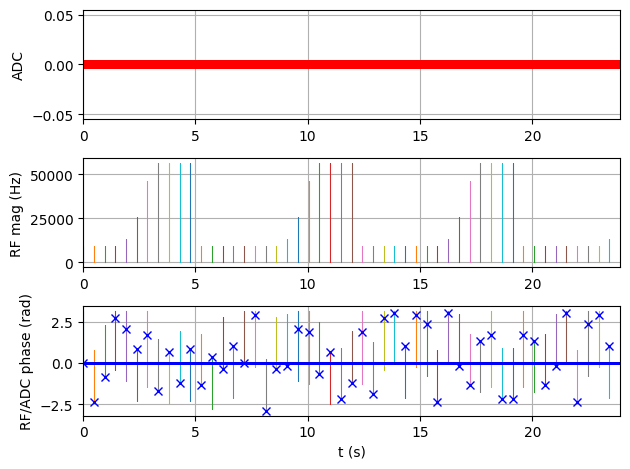

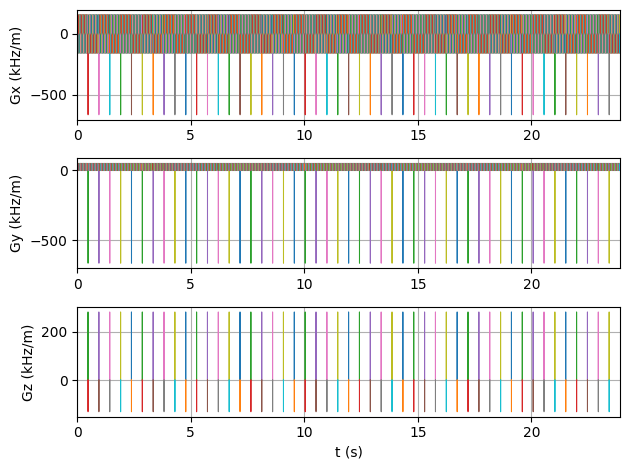

In [14]:
import numpy as np
from pypulseq.Sequence.sequence import Sequence
from pypulseq.calc_rf_center import calc_rf_center
from pypulseq.calc_duration import calc_duration
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trapezoid import make_trapezoid
from pypulseq.opts import Opts
import matplotlib.pyplot as plt
import MRzeroCore as mr0
import torch

# System limits and timing
system = Opts(max_grad=32, grad_unit='mT/m', max_slew=130,
              slew_unit='T/m/s', rf_ringdown_time=30e-6,
              rf_dead_time=100e-6, adc_dead_time=20e-6,
              grad_raster_time=10e-6,
              rf_raster_time=1e-6)

# Create a new sequence object
seq = Sequence(system)

# Sequence parameters
fov = 256e-3  # FOV in meters
n = 256  # Matrix size
slice_thickness = 4.5e-3  # Slice thickness in meters
tr_times = np.loadtxt('tr.txt')  # Load TR times
fa_angles = np.loadtxt('fa.txt')  # Load flip angles
R = 2

# Derived parameters
delta_k = 1 / fov
kmax = n / 2 * delta_k
grad_raster = system.grad_raster_time
readout_time = 6.4e-3  # Increased for better sampling
echo_spacing = 0.5e-3  # Reduced for faster traversal
rf_duration = np.ceil(1e-3 / grad_raster) * grad_raster
te = 18e-3

def make_rf_slice(flip_angle):
    """Create RF and slice select gradients"""
    rf = make_sinc_pulse(flip_angle=flip_angle,
                        system=system,
                        duration=rf_duration,
                        slice_thickness=slice_thickness,
                        apodization=0.5,
                        time_bw_product=4,
                        phase_offset=0,
                        use='excitation')

    gz = make_trapezoid(channel='z',
                       system=system,
                       duration=rf_duration,
                       area=1 / slice_thickness)

    gz_reph = make_trapezoid(channel='z',
                            system=system,
                            area=-gz.area / 2,
                            duration=1e-3)

    return rf, gz, gz_reph

def make_epi_readout(phase_enc_start=-kmax):
    """Create continuous EPI readout gradients"""
    # Pre-phasing gradient
    pre_time = 1e-3
    gx_pre = make_trapezoid(channel='x', system=system,
                           area=-kmax,
                           duration=pre_time)
    
    gy_pre = make_trapezoid(channel='y', system=system,
                           area=phase_enc_start,
                           duration=pre_time)

    # Main readout gradient parameters
    gx_flat_time = readout_time - 2 * system.grad_raster_time
    gx_amplitude = kmax / (readout_time / 2)

    # Create ADC events
    adc_samples = n
    adc_duration = readout_time
    adc = make_adc(num_samples=adc_samples,
                  duration=adc_duration,
                  delay=0)

    # Create oscillating readout gradient
    gx = make_trapezoid(channel='x',
                       system=system,
                       amplitude=gx_amplitude,
                       flat_time=gx_flat_time,
                       rise_time=system.grad_raster_time)

    return gx_pre, gy_pre, gx, adc

def add_epi_block(seq, flip_angle, rf_phase=0):
    """Add a single EPI block to the sequence"""
    block_start_time = seq.duration()[0] if len(seq.block_events) > 0 else 0

    # RF excitation
    rf, gz, gz_reph = make_rf_slice(flip_angle)
    rf.phase_offset = rf_phase
    seq.add_block(rf, gz)
    seq.add_block(gz_reph)

    # EPI readout
    gx_pre, gy_pre, gx, adc = make_epi_readout()
    seq.add_block(gx_pre, gy_pre)

    # Number of phase encoding lines
    ny = 72  # Reduced for acceleration
    
    # Calculate blip gradient moment
    delta_ky = delta_k * R  # Multiply by R for undersampling
    
    for line in range(ny):
        # Alternate readout gradient polarity
        if line > 0:
            gx.amplitude = -gx.amplitude
        
        # Add readout gradient and ADC
        seq.add_block(gx, adc)
        
        # Add blip gradient except for last line
        if line < ny - 1:
            gy_blip = make_trapezoid(channel='y',
                                   system=system,
                                   area=delta_ky,
                                   duration=0.2e-3)
            seq.add_block(gy_blip)

    return seq.duration()[0] - block_start_time

# Main sequence creation
rf_phase = 0
rf_spoiling_inc = 117

# Convert TR times from ms to seconds
tr_times = tr_times * 1e-3

for flip_angle, tr in zip(fa_angles, tr_times):
    # Add EPI block
    block_duration = add_epi_block(seq, flip_angle, rf_phase)
    
    # Update RF spoiling phase
    rf_phase = (rf_phase + rf_spoiling_inc) % 360
    rf_spoiling_inc = (rf_spoiling_inc + 117) % 360
    
    # Add delay to match TR
    if block_duration < tr:
        seq.add_block(make_delay(tr - block_duration))

# Write and plot sequence
seq.write("mrf_epi_corrected.seq")
seq.plot()
plt.show()

In [15]:
# Simulation and reconstruction
signal = mr0.util.simulate_2d(seq)

Calculating repetition 50 / 50 - done


In [16]:
# Calculate actual acquired lines
lines_acquired = int(n * 9/16 * 1/R)
kspace_adc = torch.reshape((signal), (lines_acquired, n, len(tr_times))).clone()

In [17]:
kspace_adc.shape

torch.Size([72, 256, 50])

C:\Users\perez\AppData\Local\Temp\ipykernel_314864\236729152.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(np.abs(kspace_time_step) + 0.5) *  + 100, cmap='gray')


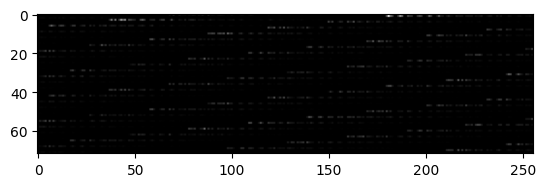

In [18]:
kspace_time_step = kspace_adc[:, :, 2]
plt.imshow(np.log(np.abs(kspace_time_step) + 0.5) *  + 100, cmap='gray')
plt.show()

In [23]:
kspace_time_step[0]
kspace_slice = torch.tensor(kspace_time_step)
kspace_slice.shape
# kspace_slice = kspace_slice.squeeze()
# kspace_slice = torch.transpose(kspace_slice, 0, 1)

for idx, k_idx in enumerate(acquired_line_indices):
    if idx % 2 == 0:
        kspace[:, k_idx, time_step] = kspace_adc[:, idx, time_step]
    else:
        kspace[:, k_idx, time_step] = torch.flip(kspace_adc[:, idx, time_step], [0])
            
# # FFT reconstruction
# spectrum = torch.fft.fftshift(kspace_slice)
# space = torch.fft.fft2(spectrum)
# space = torch.fft.ifftshift(space)

C:\Users\perez\AppData\Local\Temp\ipykernel_314864\2254712626.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kspace_slice = torch.tensor(kspace_time_step)


torch.Size([72, 256])

In [24]:
def complete_kspace(kspace_adc, n=256, partial_factor=9/16, R=2):
    """
    Complete k-space considering partial Fourier (9/16) and acceleration (R=2)
    
    Args:
        kspace_adc: Input acquired k-space data (lines_acquired x n x time_points)
        n: Full matrix size (default: 256)
        partial_factor: Partial Fourier factor (default: 9/16)
        R: Acceleration factor (default: 2)
    
    Returns:
        Completed k-space (n x n x time_points)
    """
    # Get dimensions
    lines_acquired = kspace_adc.shape[0]
    time_points = kspace_adc.shape[2]
    
    # Initialize full k-space
    kspace = torch.zeros((n, n, time_points), dtype=torch.complex64)
    
    # Calculate center line of k-space
    center_line = n // 2
    
    # Calculate number of lines acquired before and after center
    total_lines = int(n * partial_factor)  # Total lines with partial Fourier
    lines_after_center = (total_lines - center_line) // R  # Account for acceleration
    lines_before_center = lines_acquired - lines_after_center
    
    # Fill acquired data
    # Before center (fully sampled region)
    for i in range(lines_before_center):
        kspace_line = center_line - lines_before_center + i
        acq_line = i
        kspace[kspace_line, :, :] = kspace_adc[acq_line, :, :]
    
    # After center (accelerated region)
    for i in range(lines_after_center):
        kspace_line = center_line + i * R  # Account for acceleration
        acq_line = lines_before_center + i
        kspace[kspace_line, :, :] = kspace_adc[acq_line, :, :]
    
    # Complete partial Fourier using conjugate symmetry
    # Note: This is a simple conjugate symmetry completion
    # More sophisticated methods like POCS could be implemented
    for i in range(n):
        if torch.all(kspace[i, :, :] == 0):  # If line is not acquired
            symmetric_line = n - 1 - i
            if not torch.all(kspace[symmetric_line, :, :] == 0):  # If symmetric line exists
                kspace[i, :, :] = torch.conj(torch.flip(kspace[symmetric_line, :, :], [0]))
    
    # Simple linear interpolation for missing lines due to acceleration
    # Note: More sophisticated parallel imaging reconstruction could be implemented
    for t in range(time_points):
        for i in range(1, n-1):
            if torch.all(kspace[i, :, t] == 0):  # If line is missing
                # Find nearest non-zero lines
                prev_line = i - 1
                while prev_line >= 0 and torch.all(kspace[prev_line, :, t] == 0):
                    prev_line -= 1
                    
                next_line = i + 1
                while next_line < n and torch.all(kspace[next_line, :, t] == 0):
                    next_line += 1
                
                # If both surrounding lines are found, interpolate
                if prev_line >= 0 and next_line < n:
                    weight = (i - prev_line) / (next_line - prev_line)
                    kspace[i, :, t] = (1 - weight) * kspace[prev_line, :, t] + weight * kspace[next_line, :, t]
    
    return kspace

In [28]:
res = complete_kspace(kspace_adc)
res.shape
kspace_slice_test = res[:, :, 1]

C:\Users\perez\AppData\Local\Temp\ipykernel_314864\3744584940.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(np.abs(kspace_slice_test) + 0.5) *  + 100, cmap='gray')


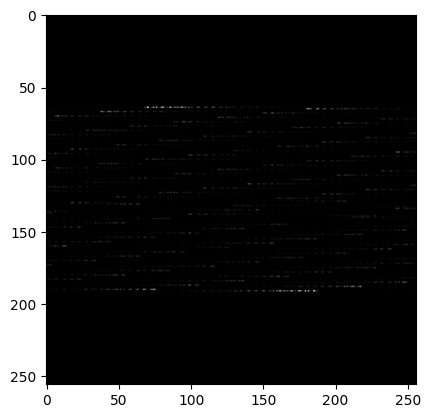

In [29]:
plt.imshow(np.log(np.abs(kspace_slice_test) + 0.5) *  + 100, cmap='gray')
plt.show()

In [34]:
kspace_slice

tensor([[-0.0000e+00+0.0000e+00j, -0.0000e+00+0.0000e+00j,
         -0.0000e+00+0.0000e+00j,  ...,
          2.5817e-04+4.6667e-05j, -4.0691e-04+1.5011e-04j,
          8.0836e-05-2.6930e-04j],
        [-0.0000e+00+0.0000e+00j,  1.3877e-04+1.6760e-04j,
          2.9743e-05-4.3235e-04j,  ...,
         -6.2020e-03+3.9674e-03j,  1.3895e-02+3.4608e-03j,
         -2.9646e-03+2.6046e-04j],
        [-0.0000e+00+0.0000e+00j,  2.5926e-03-4.8067e-03j,
          1.8279e-03-7.1005e-03j,  ...,
         -0.0000e+00+0.0000e+00j, -0.0000e+00+0.0000e+00j,
         -0.0000e+00+0.0000e+00j],
        ...,
        [-0.0000e+00+0.0000e+00j,  9.0915e-08-1.0887e-08j,
         -2.0968e-07+3.3621e-07j,  ...,
         -7.9451e-05+3.3155e-05j,  1.0184e-04-1.1769e-04j,
          7.5386e-05+8.2220e-06j],
        [-0.0000e+00+0.0000e+00j, -9.8939e-05-4.4686e-05j,
         -8.7591e-05-4.8186e-07j,  ...,
          1.2696e-02-6.6613e-04j, -6.5163e-03+5.9106e-03j,
         -4.1308e-03+3.6194e-04j],
        [-0.0000e+00+0

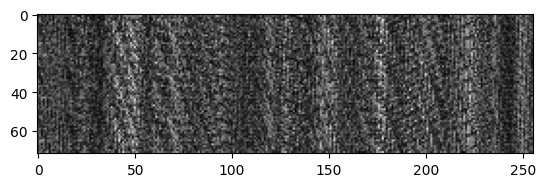

In [38]:
spectrum = torch.fft.fftshift(kspace_slice)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)
plt.imshow(torch.abs(space), cmap='gray')
plt.show()